# MLBD Project : Simplified Human Activity Recognition w/Smartphone

1. Feature selection
2. Model
3. Prediction

# Loading and preprocessing dataset

X_train : (2418, 561)
X_test: (1191, 561)
X_train : (2418,)
y_test: (1191,)
5 0


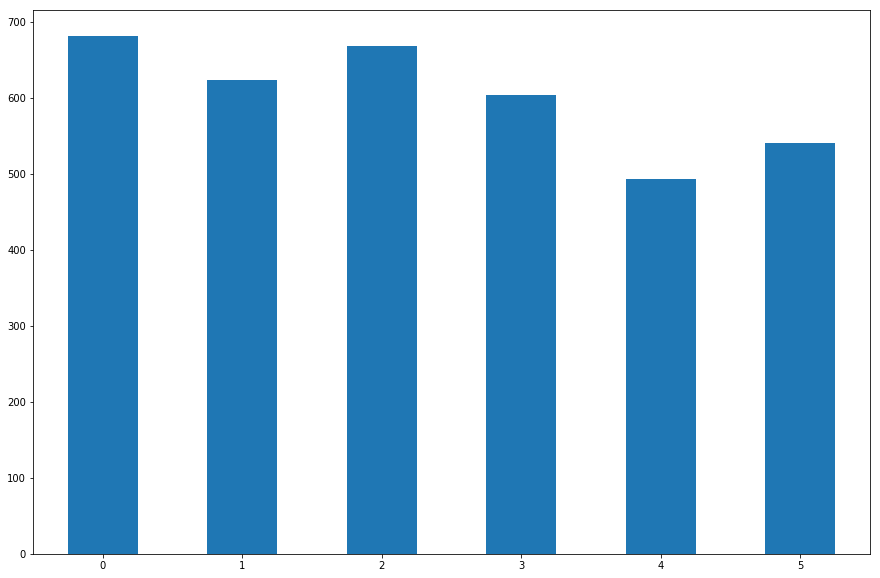

In [46]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import GridSearchCV

data_train = pd.read_csv("dataset/train.csv")
# data_test = pd.read_csv("dataset/test.csv")

# Separate X and y
X = data_train.values[:,2:]
y_label = data_train.values[:,1]

# Encode y
le = preprocessing.LabelEncoder()
y = le.fit_transform(y_label)

# Split dataset to test and train
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

print(f"X_train : {X_train.shape}")
print(f"X_test: {X_test.shape}")
print(f"X_train : {y_train.shape}")
print(f"y_test: {y_test.shape}")

def bins_labels(bins, **kwargs):
    bin_w = (max(bins) - min(bins)) / (len(bins) - 1)
    plt.xticks(np.arange(min(bins)+bin_w/2, max(bins), bin_w), bins, **kwargs)
    plt.xlim(bins[0], bins[-1])

print(y.max(), y.min())
    
plt.figure(figsize=(15,10))
bins = range(7)
plt.hist(y, bins=bins,rwidth=0.5)
bins_labels(bins)
plt.show()

# Features selection

Creation of a list that will contain all lists of features indexes resulting of different feature selection implemented

In [47]:
list_indexes = []
list_indexes.append([x for x in range(X_train.shape[1])])

## VarianceThreshold feature selection

We remove features with low variance. Here we keep only features with variance greater than 20%, so it will remove all features that have a high probability of beeing similar along the entries.

In [48]:
from sklearn.feature_selection import VarianceThreshold

sel = VarianceThreshold(threshold=(0.2))
X_train_selected = sel.fit_transform(X_train)
indices = sel.get_support(indices=True)
print(X_train_selected.shape)

list_indexes.append(indices)

(2418, 59)


## Univariate feature selection

We only keep the K features with highest score. Score is computed using statistical method, here we use chi2.
Chi2 need variables to be non-neative. As all variables are in the interval [-1,1] we can simply add 1 to all variables for this step.

In [49]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

kbest=SelectKBest(chi2, k=150)
# All features are [-1,1] but this must be non-negative, so we add 1 to all features
X_train_selected = kbest.fit_transform(X_train + 1, y_train)
indices = kbest.get_support(indices=True)
print(X_train_selected.shape)

list_indexes.append(indices)

(2418, 150)


# Training

First, we delcare our results dictionnary. Then, for each classifier, we will iteratre through `list_indexes`, train and compute accuracy, and finally push the result inside the `results` dictionnary.

In [50]:
results = {}

## KNN

In [8]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_jobs=8)
params = {"n_neighbors": [1,3,5,7], "p": [1,2,3], "leaf_size": [5, 10, 30, 60]}


results_knn = {}

for i, indexes in enumerate(list_indexes):
    clf = GridSearchCV(knn, params, cv=5)

    clf.fit(X_train[:,indexes], y_train)

    y_predicted = clf.predict(X_test[:,indexes])

    score = accuracy_score(y_test, y_predicted)
    cm = confusion_matrix(y_test, y_predicted)
    print(score)
    print(cm)

    print(clf.best_params_)
    
    results_knn[i]={"accuracy":score,"conf_mat":cm}

results["knn"] = results_knn

KeyboardInterrupt: 

## MLP

In [ ]:
from sklearn.neural_network import MLPClassifier

mlpc = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(5, 10), random_state=1)
params = {"solver":["lbfgs"], "alpha":[1e-5, 1e-4,1e-3,1e-6], 
          "hidden_layer_sizes":[(5,10)], "max_iter":[200,250,300]}

results_mlp={}

for i, indexes in enumerate(list_indexes):
    clf = GridSearchCV(mlpc, params, cv=5)

    clf.fit(X_train[:,indexes], y_train)

    y_predicted = clf.predict(X_test[:,indexes])

    score = accuracy_score(y_test, y_predicted)
    cm = confusion_matrix(y_test, y_predicted)
    print(score)
    print(cm)

    print(clf.best_params_)
    
    results_mlp[i]={"accuracy":score,"conf_mat":cm}

results["mlp"]=results_mlp

## SVM

In [ ]:
from sklearn import svm

params = {"C":[0.1, 0.5, 1.0, 2.0, 10.0, 50.0, 100.0, 200.0, 500.0, 1000.0], 
          "kernel":['linear', 'rbf', 'sigmoid'], 'decision_function_shape':['ovo','ovr']}

svc = svm.SVC(gamma='scale')

results_svm={}

for i, indexes in enumerate(list_indexes):
    clf = GridSearchCV(svc, params, cv=5)

    clf.fit(X_train[:,indexes], y_train)

    y_predicted = clf.predict(X_test[:,indexes])

    score = accuracy_score(y_test, y_predicted)
    cm = confusion_matrix(y_test, y_predicted)
    print(score)
    print(cm)

    print(clf.best_params_)
    
    results_svm[i]={"accuracy":score,"conf_mat":cm}

results["svm"]=results_svm

# KMeans

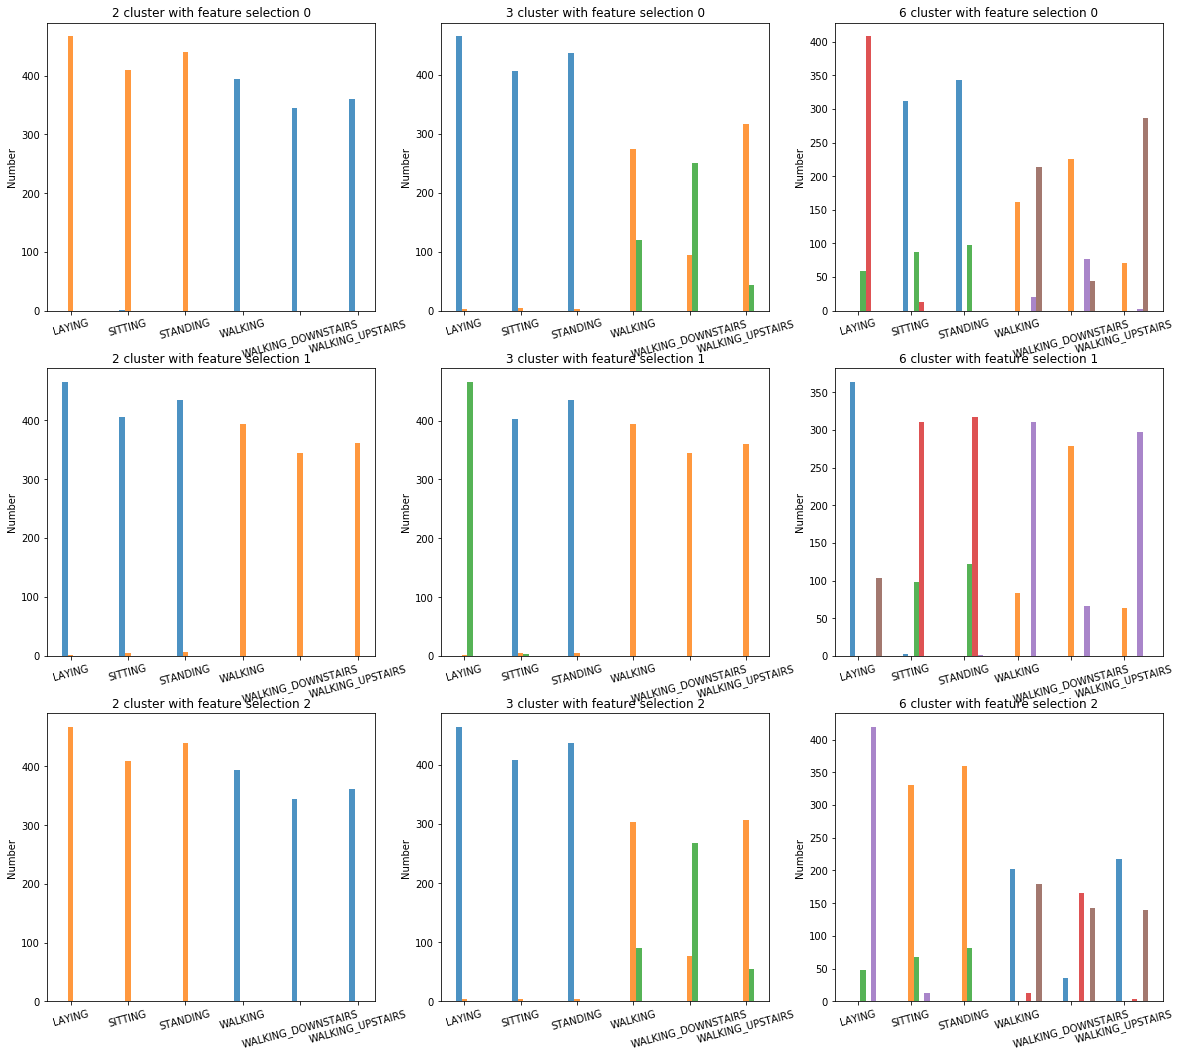

In [132]:
from sklearn.cluster import KMeans

nb_label = 6
nb_clusters = [2,3,6]

plt.figure(figsize=(20,18))

for i, indexes in enumerate(list_indexes):
    
    for k, nb_cluster in enumerate(nb_clusters):
    
        kmeans = KMeans(n_clusters=nb_cluster, n_jobs=4)
        kmeans.fit(X_train[:,indexes])

        fig = plt.subplot(len(list_indexes),len(nb_clusters),i*len(nb_clusters)+k+1)
        
        index = np.arange(nb_label)
        bar_width = 0.1
        opacity = 0.8

        for j in range(0,nb_cluster):
            index_cluster=[index for index,value in enumerate(kmeans.labels_) if value == j]

            counts = np.bincount(y_train[index_cluster],minlength=nb_label)
#             print(counts)
            bar = plt.bar(index + bar_width * j, counts, bar_width, alpha=opacity, label='Cluster'+str(j))


        plt.legend().set_visible(False)
        plt.ylabel('Number')
        plt.title(str(nb_cluster)+' cluster with feature selection '+str(i))
        plt.xticks(index + bar_width, [le.inverse_transform([x])[0] for x in range(0,nb_label)], rotation=15)

        
plt.show()



# Results

In [ ]:
# Just for test
results_test={}
results_test[0]={"accuracy":0.2,"conf_mat":results["svm"][0]["conf_mat"]}
results_test[1]={"accuracy":0.2,"conf_mat":results["svm"][0]["conf_mat"]}
results["mlp"]=results_test
# Just for test

models_names = list(results.keys())

accuracies = [[acc["accuracy"] for acc in list(model.values())] for model in results.values()]

print(accuracies)


plt.matshow(accuracies)
plt.title("Accuracy")
plt.xticks(np.arange(len(models_names)), models_names)
plt.xlabel("Model")
plt.yticks(np.arange(len(accuracies[0])), np.arange(len(accuracies[0])))
plt.ylabel("Index")

for (i, j), z in np.ndenumerate(accuracies):
    plt.text(j, i, '{:0.1f}'.format(z),bbox=dict(boxstyle='round', facecolor='white', edgecolor='0.3'))

plt.show()

In [ ]:
# Results